In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.ts_reader import MultiModalDataset,VitalSignsDataset,vital_pre_train
from model.autoencoder_v3 import *
from model.autoencoder_v3_loss_train import *
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import torch.optim as optim
import torch
torch.cuda.empty_cache()
import  json

In [2]:

vital_signs_train = '/home/mei/nas/docker/thesis/data/hdf/train/ts_each_patient.h5'
vital_signs_val = '/home/mei/nas/docker/thesis/data/hdf/val/ts_each_patient.h5'
vital_signs_test = '/home/mei/nas/docker/thesis/data/hdf/test/ts_each_patient.h5'

train_dataset = VitalSignsDataset(vital_signs_train)
val_dataset = VitalSignsDataset(vital_signs_val)
test_dataset = VitalSignsDataset(vital_signs_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=vital_pre_train)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=vital_pre_train) 
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=vital_pre_train)

In [3]:
from torch.utils.data import DataLoader, TensorDataset

small_data_iter = iter(train_loader) 
inputs, lengths = next(small_data_iter)   

small_dataset = TensorDataset(inputs, lengths)
small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "/home/mei/nas/docker/thesis/data/model_results/autoencoder_v3"

model  = PatientAutoencoder(
    n_features=154, embedding_dim=128,  n_heads=2,
                 som_grid=(10,10)
).to(device)

In [ ]:
stage1_dir = os.path.join(base_dir, "stage1")

pretrain_epochs  = 100
prior_max        = 1e-5
anneal_steps     = 200
opt_vae = optim.Adam(model.parameters(), lr=1e-3)

model1, hist_pre = pretrain_ae(
    model,
    loader=train_loader,
    optimizer=opt_vae,
    device=device,
    checkpoint_dir=stage1_dir,
    epochs=pretrain_epochs,
)

[Pretrain V3] Epoch 10/10 Loss=0.0890
  ➡ Saved checkpoint: /home/mei/nas/docker/thesis/data/model_results/autoencoder_v3/stage1/pretrain_epoch010.pth


In [ ]:
stage2_dir = os.path.join(base_dir, "stage2")
os.makedirs(stage2_dir, exist_ok=True)

som_epochs_stage = 50//3
som_lrs=(0.1,0.01,0.001)
grid_size=(10,10)

model2,hist_som = train_som_only(
    model1,
    loader=train_loader,
    device=device,
    checkpoint_dir=stage2_dir,
    start_epoch=1,
    epochs_per_stage=som_epochs_stage,
    lrs=som_lrs,
    grid_size=grid_size
)


[SOM Init lr=0.100] Epoch 3/9 | Loss: 14.7375 | Saved /home/mei/nas/docker/thesis/data/model_results/autoencoder_v3/stage2/som_stage1_ep3.pth
[SOM Init lr=0.010] Epoch 6/9 | Loss: 13.5708 | Saved /home/mei/nas/docker/thesis/data/model_results/autoencoder_v3/stage2/som_stage2_ep3.pth
[SOM Init lr=0.001] Epoch 9/9 | Loss: 13.3848 | Saved /home/mei/nas/docker/thesis/data/model_results/autoencoder_v3/stage2/som_stage3_ep3.pth


In [ ]:
joint_epochs=100
base_lr=1e-3
decay=0.99
weights = {
        'recon': 1.0, 'cluster': 1.0,
        'ssom': 10.0, 'smooth': 1.0, 
        'cluster_k': 2.0
    }


stage3_dir = os.path.join(base_dir, "stage3")
os.makedirs(stage3_dir, exist_ok=True)

model3,hist_joint = train_joint(
    model2,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    checkpoint_dir=stage3_dir,
    start_epoch=1,
    epochs=joint_epochs,
    base_lr=base_lr,
    decay=decay,
    weights=weights,
    grid_size=(10,10)
)


 Epoch 10/10 | Train=130.9271 | Val=130.7740 | Saved /home/mei/nas/docker/thesis/data/model_results/autoencoder_v3/stage3/joint_epoch010.pth


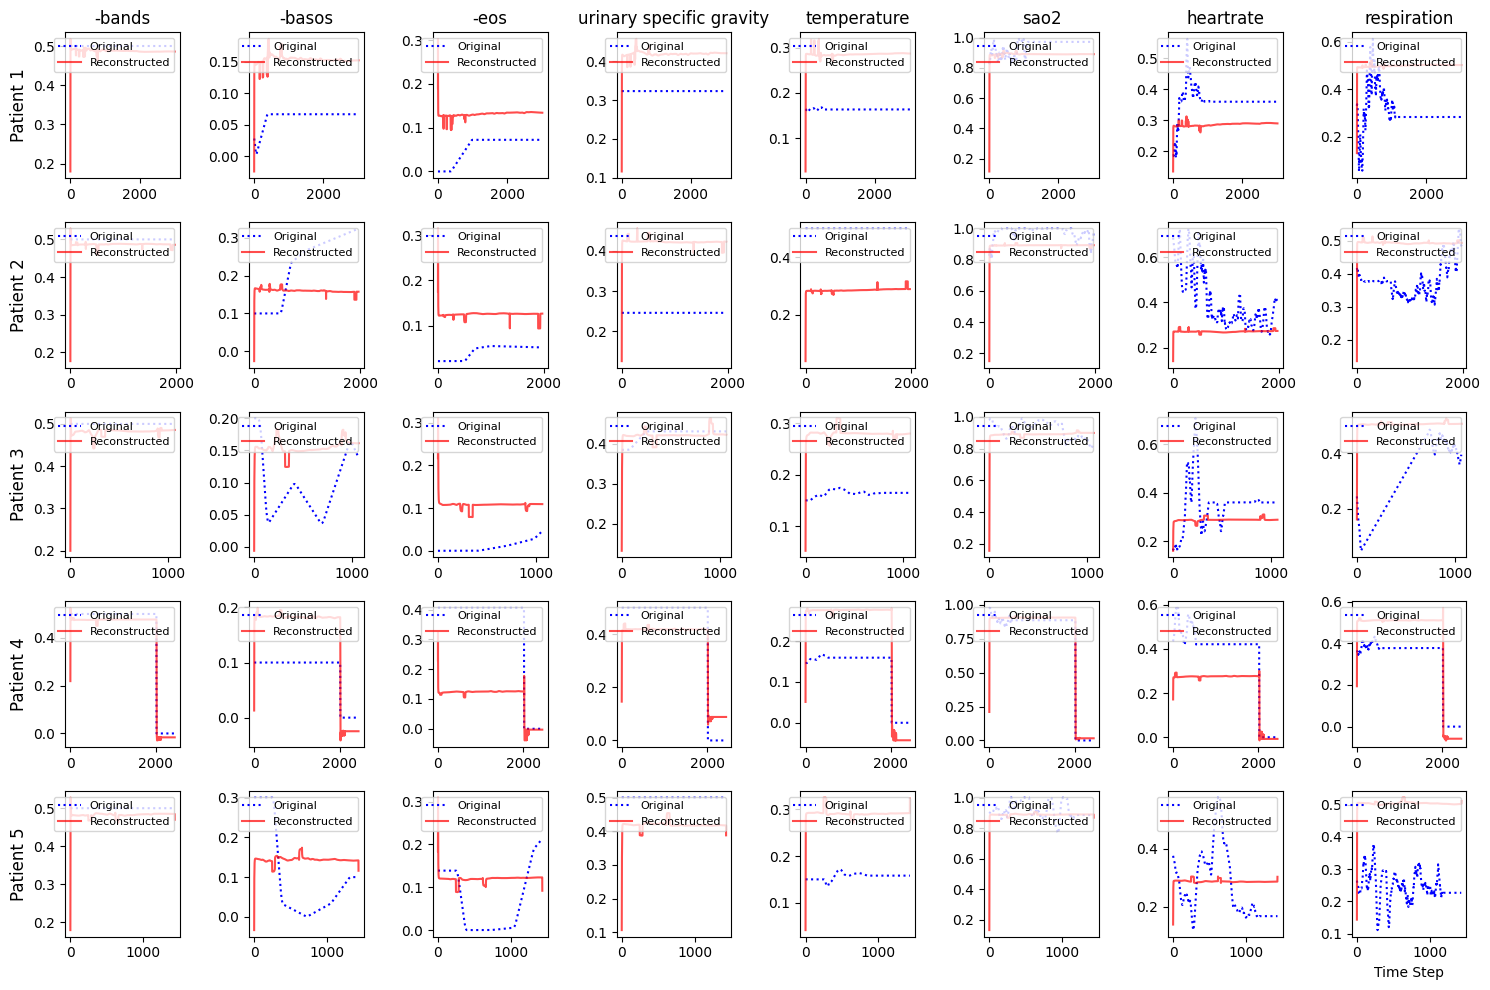

In [9]:
with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    features = [line.strip() for line in f]

selected_feature_indices = [0,1,2,142,143,144,145,146]  #

visualize_recons(model3, test_loader, num_patients=5, feature_indices=selected_feature_indices, feature_names=features,device=device)